<a href="https://colab.research.google.com/github/dudco0040/dudco0040/blob/master/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%87%BC%ED%95%91_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**네이버 쇼핑 리뷰 감성분류하기✌**

```

```



In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 58.6 MB/s 
     |████████████████████████████████| 448 kB 59.3 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-12 08:51:37--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f5f095a25d0>)

In [4]:
#전제 리뷰 개수 출력
total_data = pd.read_table('ratings_total.txt', names = ['ratings','reviews'])  #리뷰
print('전체 리뷰 개수:', len(total_data))

전체 리뷰 개수: 200000


In [5]:
#데이터 확인
total_data[:10]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


In [6]:
#label(긍정,중립,부정) 분리하기
#1:부정, 2~4:중립, 5:긍정
total_data['label'] = np.select([(total_data.ratings==5),(total_data.ratings==4),(total_data.ratings==2),(total_data.ratings==1)], 
                                ["Positive","Neutral","Neutral","Negative"])
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,Positive
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,Neutral
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,Positive
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,Neutral
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,Positive


In [7]:
#별점(ratings) 분포
total_data['ratings'].value_counts()
#train_data['ratings'].value_counts().plot(kind = 'bar')

5    81177
2    63989
1    36048
4    18786
Name: ratings, dtype: int64

In [8]:
#label(Positive,Neutral,Negative) 분포
total_data['label'].value_counts()

Neutral     82775
Positive    81177
Negative    36048
Name: label, dtype: int64

In [9]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 3)

In [10]:
#reviews 중복 제거 
total_data.drop_duplicates(subset=['reviews'],inplace=True)
print("총 샘플의 수: ",len(total_data))

총 샘플의 수:  199908


In [11]:
#train/test data 나누기
train_data, test_data = train_test_split(total_data, test_size= 0.25, random_state= 42)
print('훈련용 리뷰의 개수:',len(train_data))
print('테스트용 리뷰의 개수:',len(test_data))

훈련용 리뷰의 개수: 149931
테스트용 리뷰의 개수: 49977


In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

      label  count
0  Negative  27091
1   Neutral  61818
2  Positive  61022


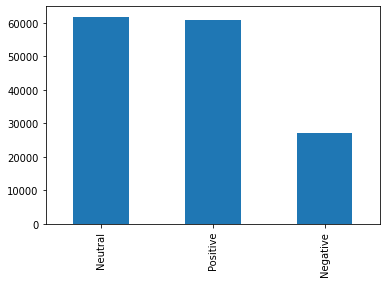

In [13]:
#시각화
train_data['label'].value_counts().plot(kind = 'bar')

In [14]:
#학습데이터(train datat) 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
train_data['reviews'].replace('',np.nan,inplace = True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [15]:
#테스트데이터(test data) 한글과 공백을 제외하고 모두 제거
test_data.drop_duplicates(subset=['reviews'],inplace=True) #중복제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('',np.nan,inplace = True)
test_data = test_data.dropna(how = 'any')
print("전처리 후 테스트용 샘플의 개수:" ,len(test_data))

전처리 후 테스트용 샘플의 개수: 49977


In [16]:
mecab = Mecab()

#불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

negative_words = np.hstack(train_data[train_data.label == "Negative"]['tokenized'].values)
neutrality_words = np.hstack(train_data[train_data.label == "Neutral"]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == "Positive"]['tokenized'].values)

negative_word_count = Counter(negative_words)
neutrality_words_count = Counter(neutrality_words)
positive_words_count = Counter(positive_words)

print("부정 리뷰")
print(negative_word_count.most_common(20))
print("중립 리뷰")
print(neutrality_words_count.most_common(20))
print("긍정 리뷰")
print(positive_words_count.most_common(20))

부정 리뷰
[('네요', 10901), ('안', 7990), ('는데', 7811), ('어요', 5145), ('너무', 4617), ('있', 4532), ('했', 4350), ('구매', 3689), ('없', 3503), ('어', 3426), ('배송', 3342), ('되', 3316), ('거', 3240), ('습니다', 3152), ('그냥', 2934), ('좋', 2892), ('같', 2879), ('만', 2660), ('나', 2639), ('않', 2621)]
중립 리뷰
[('네요', 22974), ('는데', 14225), ('좋', 13588), ('어요', 12066), ('안', 11844), ('있', 11125), ('아요', 9871), ('했', 8999), ('너무', 8849), ('잘', 8570), ('배송', 8230), ('같', 7804), ('습니다', 7494), ('구매', 7206), ('어', 6918), ('거', 6653), ('않', 6257), ('되', 5871), ('없', 5483), ('것', 5443)]
긍정 리뷰
[('좋', 31595), ('아요', 16014), ('네요', 14777), ('잘', 14708), ('어요', 14479), ('구매', 13444), ('습니다', 10676), ('배송', 9819), ('있', 9481), ('는데', 9148), ('합니다', 7975), ('먹', 7807), ('재', 7800), ('했', 7788), ('너무', 7258), ('만족', 5888), ('같', 5588), ('아', 5238), ('어', 5213), ('쓰', 4983)]


In [17]:
#fig,(ax1,ax2,ax3) = plt.subplots(1,2,figsize=(10,5))

#text_len = train_data[train_data['label']=='Positive']['tokenized'].map(lambda x: len(x))
#ax1.hist(text_len, color='red')
#ax1.set_title('Positive Reviews')
#ax1.set_xlabel('length of samples')
#ax1.set_ylabel('number of samples')
#print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

#text_len = train_data[train_data['label']=='Neutral']['tokenized'].map(lambda x: len(x))
#ax2.hist(text_len, color = 'red')
#ax2.set_title('Neutral Reviews')
#ax2.set_xlabel('length of samples')
#ax2.set_ylabel('number of samples')
#print('중립 리뷰의 평균 길이 :', np.mean(text_len))

#text_len = train_data[train_data['label']=='Negative']['tokenized'].map(lambda x: len(x))
#ax3.hist(text_len, color='blue')
#ax3.set_title('Negative Reviews')
#fig.suptitle('Words in texts')
#ax3.set_xlabel('length of samples')
#ax3.set_ylabel('number of samples')
#print('부정 리뷰의 평균 길이 :', np.mean(text_len))
#plt.show()

In [18]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [19]:
train_data.head()

,ratings,reviews,label,tokenized
59666,2,사이즈를센치씩늘린건데도작아요그리고색상은완전달라요칙칙한핑크네요ㅠㅠ많이아쉽지만암막효과는좋아요,Neutral,"[사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ..."
12433,2,ㅂ불만족빗이아픔멍이피부에빗질못해주겟네요,Neutral,"[ㅂ, 불, 만족, 빗이, 아, 픔멍이피부에빗질못해주겟네요]"
146516,1,이제품쓰고삼일만에변기물이잘안내려갔어요혹시나해서다시빼보니물이다시잘내려가네요이많은걸다어...,Negative,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서..."
158109,5,적당하고만족합니다,Positive,"[적당, 만족, 합니다]"
70219,2,편하자고이용하는밀키튼데손은근많이가서저는패쓰요,Neutral,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 근, 많이, 서, 저, 패, 쓰, 요]"


In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트(한 글자인 단어 제거)
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for keys, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  #단어 등장 빈도수가 threshold보다 작으면
  if(value<threshold):
    rare_cnt = rare_cnt+1
    rare_freq = rare_freq+value

print("단어 집합(vocabulary)의 크기:",total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기: 51331
등장 빈도가 1번 이하인 희귀 단어의 수: 27839
단어 집합에서 희귀 단어의 비율: 54.23428337651711
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2553520094695902


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 23494


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
print(X_train[:3])

[[64, 2081, 296, 14978, 257, 71, 6, 243, 163, 134, 783, 3060, 626, 2, 1], [457, 408, 50, 8677, 25, 1], [43, 24, 837, 111, 36, 2439, 179, 7, 10, 8172, 4, 1257, 29, 137, 320, 44, 58, 179, 137, 7, 1913, 1996, 109, 162, 1414, 330, 121, 135]]


In [24]:
print(X_test[:3])

[[14, 690, 749, 112, 187, 246, 12], [334, 3869, 62, 4182, 1633], [11, 68, 2, 48, 156, 3, 27, 15, 6, 555, 285, 16, 90, 108, 589, 58, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 14.790970513102694


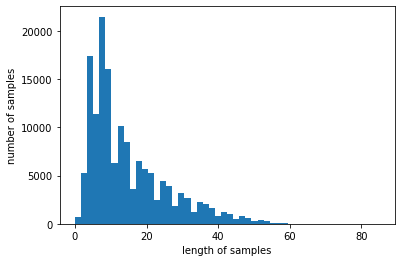

In [40]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence)<=max_len):
      count = count+1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len,(count/len(nested_list))*100))

  max_len = 80
  below_threshold_len(max_len,X_train)
  X_train = pad_sequences(X_train, maxlen= max_len)
  X_test = pad_sequences(X_test, maxlen= max_len)

In [37]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])


In [ ]:
history = model.fit(X_train,y_train,epochs=10, callbacks = [es,mc], batch_size = 64, validation_split =0.2)

In [31]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f"%(loaded_model.evaluate(X_test,y_test)[1]))

OSError: ignored

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣','',new_sentence)
  new_sentence = mecab.morphs(new_sentence) #토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords]  #불용어 제거
  encodeed = tokenizer.texts_to_sequences([new_sentence]) #정수 인코딩
  pad_new = pad_sequences(encoded, maxlen=max_len) #패딩

  score = float(loaded_model.predict(pad_new)) #예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
  elif():
    print("{:.2f}% 확률로 중립 리뷰입니다.".format(1-score*100))
  else:
    pritn("{:.2f}% 확률로 부정 리뷰입니다.".format(score*100))
    